# Augmented Reality

## Introduction

First step is to calibrate camera to get intrinsic params


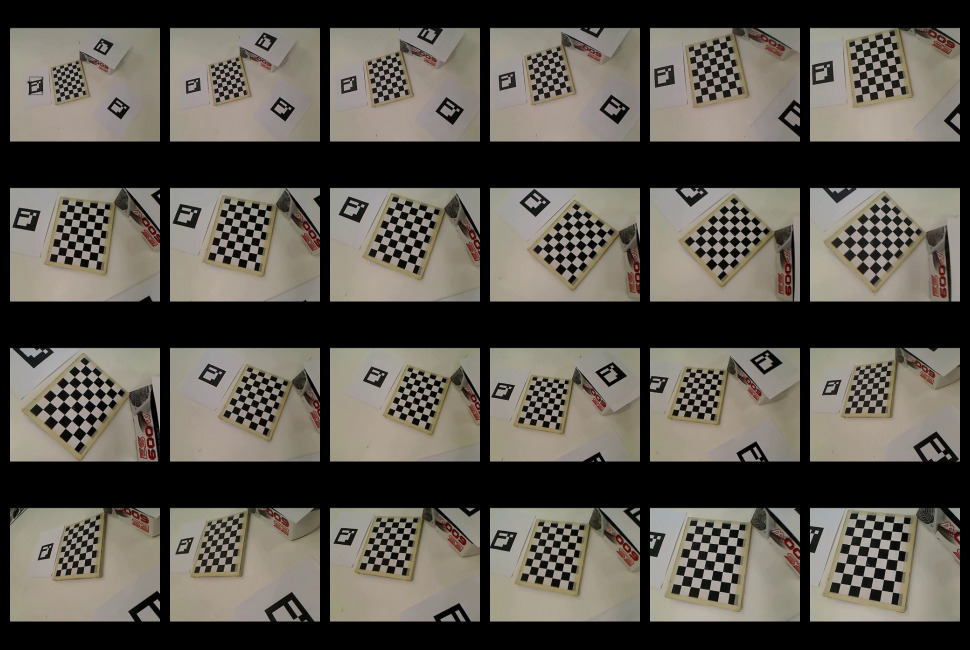

Results
\begin{pmatrix}
413.6727 & 0   & 311.9351  \\
0 & 411.3367  & 224.0175  \\
0 &  0& 1  \\
\end{pmatrix}

Distortion

\begin{pmatrix}
0.07395 & -0.09413   & -0.00686 & -.00327 & 0  \\
\end{pmatrix}

## Target Detection

In [ ]:
import numpy as np
import cv2 as cv
from PIL import Image
from OpenGL.GL import *
from OpenGL.GLUT import *
from OpenGL.GLU import *
from objloader import *


# Returns the intrinsic matrix calculated during calibration
def get_intrinsic_matrix():
    intrinsic_matrix = np.array([[413.6727, 0, 311.9351],
                                 [0, 411.3367, 224.0175],
                                 [0, 0, 1]])
    return intrinsic_matrix


# Returns the distortion parameters from calibration
def get_distortion():
    distortion = np.array([[0.07], [-0.09], [-0.006], [-0.003], [0.0]])
    return distortion


# Returns the 3D coordinates of the target
def get_original_3d_corners(original_target):
    x_t = original_target.shape[0]
    y_t = original_target.shape[1]
    corners = [[0, 0, 1], [x_t, 0, 1], [x_t, y_t, 1], [0, y_t, 1]]
    return np.array(corners)


# Returns the 2D coordinates of the target
def get_original_corners(original_target):
    x_t = original_target.shape[0]
    y_t = original_target.shape[1]
    corners = [[0, 0], [x_t, 0], [x_t, y_t], [0, y_t]]
    return np.array(corners)


# Sorts coordinates in clockwise order
def sort_coordinates_clockwise(corners):
    ordered = corners[np.argsort(corners[:, 0]), :]
    left = ordered[:2, :]
    right = ordered[2:, :]
    left = left[np.argsort(left[:, 1]), :]
    (top_left, bottom_left) = left
    right = right[np.argsort(right[:, 1]), :]
    (top_right, bottom_right) = right
    sorted_corners = np.array([top_left, top_right, bottom_right, bottom_left], dtype="float32")
    return sorted_corners


In [ ]:
import cv2 as cv
import numpy as np

# Calculates the percentage of differing pixels between images and returns a coefficient between -1 and 1
def template_matching(img1, target, threshold):
    m, n = img1.shape[0], img1.shape[1]
    mn = img1.shape
    max_i = img1.size
    max_val = 0
    max_rotation = 0
    img2 = target.copy()

    for r in range(4):
        img2 = cv.rotate(img2, cv.ROTATE_90_CLOCKWISE)
        count_different = 0
        count_identical = 0

        for i, j in np.ndindex(mn):
            if img1[i][j] != img2[i][j]:
                count_different += 1
            else:
                count_identical += 1

        difference = count_identical - count_different
        coefficient = (difference - 0) / (max_i - 0)

        if coefficient >= max_val:
            max_val = coefficient
            max_rotation = r

    if max_val >= threshold:
        return True, max_rotation
    return False, 0

# Checks if there are closely located squares among detected squares
def has_duplicates(matrix, reference_points, margin):
    for i in range(len(reference_points)):
        for j in range(4):
            if (
                matrix[j][0] >= reference_points[i][j][0] - margin
                and matrix[j][0] <= reference_points[i][j][0] + margin
                and matrix[j][1] >= reference_points[i][j][1] - margin
                and matrix[j][1] <= reference_points[i][j][1] + margin
            ):
                return True
    return False


### Target and pose finding

In [ ]:
import cv2 as cv
import numpy as np

# Find edges with Canny, detect polygons with findContours, and for all polygons with 4 sides, perform homography
# Using homography, perform perspective transformation of points, and then the template matching algorithm checks for the best rotation
def find_target(frame_pb, original_target, frame_og):
    threshold = 100
    target_points = []
    rotations = []
    Rr = []
    Ttvec = []
    edges = cv.Canny(frame_pb, threshold, threshold * 2)
    contours, _ = cv.findContours(edges, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        area = cv.contourArea(cnt)
        if 1000 < area < frame_og.size / 2:
            perimeter = cv.arcLength(cnt, True)
            approx = cv.approxPolyDP(cnt, 0.05 * perimeter, True)
            if len(approx) == 4:
                approx = np.array([approx[0][0], approx[1][0], approx[2][0], approx[3][0]])
                approx = approx.reshape((4, 2))
                if not has_duplicates(approx, target_points, 50):
                    rect = cv.minAreaRect(cnt)
                    box = cv.boxPoints(rect)
                    box = np.int0(box)
                    x = min(box[:, [0]])[0]
                    y = min(box[:, [1]])[0]
                    xm = max(box[:, [0]])[0]
                    ym = max(box[:, [1]])[0]
                    cropped = frame_pb[y:ym + 1, x:xm + 1]
                    cropped_color = frame_og[y:ym + 1, x:xm + 1]
                    original_corners = get_original_corners(original_target)
                    img_frame = approx.astype(np.float32)
                    img_frame = np.array(sort_coordinates_clockwise(img_frame)).astype(np.float32)
                    pts = img_frame.copy()
                    img_frame[:, 0] = img_frame[:, 0] - (x)
                    img_frame[:, 1] = img_frame[:, 1] - (y)
                    H, status = cv.findHomography(img_frame, original_corners, cv.RANSAC, 5.0)
                    if H is not None:
                        T = cv.warpPerspective(cropped, H, ((original_target.shape)), cv.INTER_NEAREST)
                        intrinsic_matrix = get_intrinsic_matrix()
                        pts = pts.astype(np.float32)
                        original_corners_3d = get_original_3d_corners(original_target).astype(np.float32)
                        distortion = get_distortion()
                        _, vec, tvec = cv.solvePnP(original_corners_3d, pts, intrinsic_matrix, distortion)
                        R, _ = cv.Rodrigues(vec)

                        resize_dim = int(original_target.shape[0] / 12)
                        resize_dim = (resize_dim, resize_dim)
                        target_perspective = cv.resize(T, resize_dim)
                        original_target_m = original_target
                        original_target_m = cv.resize(original_target_m, resize_dim)

                        _, target_perspective = cv.threshold(target_perspective, 127, 255, cv.THRESH_BINARY)
                        _, original_target_m = cv.threshold(original_target_m, 127, 255, cv.THRESH_BINARY)
                        result, max_rotation = template_matching(target_perspective, original_target_m, 0.5)
                        if result:
                            target_points.append(pts)
                            rotations.append(max_rotation)
                            Rr.append(R)
                            Ttvec.append(tvec)
                            cv.polylines(frame_og, [approx], True, (255, 0, 0), 4, cv.LINE_AA)
    return frame_og, np.array(target_points), np.array(rotations), np.array(Rr), np.array(Ttvec)


## Draw, position and render

In [ ]:
import numpy as np
import math
from OpenGL.GL import *

# Returns a matrix for positioning Pikachu
def get_gl_matrix_pikachu(R, T, r):
    if R.size > 0 and T.size > 0:
        T[r] = T[r] / 200
        inv = np.array([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
        M = [[R[r][0][0], R[r][0][1], -R[r][0][2], T[r][0][0]],
             [R[r][1][0], R[r][1][1], -R[r][1][2], T[r][1][0]],
             [R[r][2][0], R[r][2][1], -R[r][2][2], T[r][2][0]],
             [0, 0, 0, 1]]
        return np.array(inv @ M).T
    else:
        return np.identity(4)

# Returns a matrix for positioning the cube
def get_gl_matrix_cube(R, T, r):
    if R.size > 0 and T.size > 0:
        T[r] = T[r] / 200
        inv = np.array([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
        M = [[R[r][0][0], R[r][0][1], R[r][0][2], T[r][0][0]],
             [R[r][1][0], R[r][1][1], R[r][1][2], T[r][1][0]],
             [R[r][2][0], R[r][2][1], R[r][2][2], T[r][2][0]],
             [0, 0, 0, 1]]
        return np.array(inv @ M).T
    else:
        return np.identity(4)

# Returns the rotation angles of the target
def get_rotation(r):
    if r == 3:
        return -90
    elif r == 0:
        return 0
    elif r == 1:
        return 90
    elif r == 2:
        return 180

# Adjusts the scene view based on camera's intrinsic parameters
def adjust_camera_intrinsics(w, h):
    K = get_intrinsic_matrix()
    fx = K[0, 0]
    fy = K[1, 1]
    fovy = 2 * math.atan(0.5 * h / fy) * 180 / math.pi
    aspect = (w * fy) / (h * fx)
    near = 0.1
    far = 100.0
    gluPerspective(fovy, aspect, near, far)


### OpenGl and Glut init

In [ ]:
from OpenGL.GL import *

def idle_callback():
    glutPostRedisplay()

def resize(w, h):
    glViewport(0, 0, w, h)
    glMatrixMode(GL_PROJECTION)
    glLoadIdentity()
    adjust_camera_intrinsics(w, h)
    glMatrixMode(GL_MODELVIEW)
    glLoadIdentity()
    gluLookAt(0, 0, 5, 0, 0, 0, 0, 1, 0)

def keyboard(key, x, y):
    key = key.decode('utf-8')
    
    if key == 'q':
        sys.exit()

# Initialize OpenGL
def init_opengl(dimensions):
    (w, h) = dimensions

    glClearColor(0.0, 0.0, 0.0, 0.0)
    glClearDepth(1.0)

    glEnable(GL_DEPTH_TEST)

    glMatrixMode(GL_PROJECTION)
    glLoadIdentity()

    fovy = 45
    aspect = w / h
    gluPerspective(fovy, aspect, 0.1, 100.0)


### Render Objects

In [ ]:
from OpenGL.GL import *

# Create a new matrix in the OpenGL buffer to adjust the Pikachu model
def render_pikachu(obj, r, rotations):
    glPushMatrix()
    glScalef(0.55, 0.55, 0.55)
    glTranslatef(0, 0, 1)
    if r == 3:
        glRotate(rotations[r], 0, 0, 1)
    else:
        glRotate(-rotations[r], 0, 0, 1)
    
    glCallList(obj.gl_list)
    glPopMatrix()

# Render a wireframe cube
def render_cube():
    glutWireCube(2.0)

# Render a line to indicate orientation
def render_line():
    glLineWidth(4.0)
    glBegin(GL_LINES)
    glVertex3d(0, 0, 0)
    glVertex3d(3, 0, 0)
    glEnd()
    glLineWidth(1.0)


### Main glut loop

In [ ]:
from OpenGL.GL import *

# Render the background and position objects
def display_callback():
    ret, frame = cap.read()
    grayscale_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    ret, grayscale_frame = cv.threshold(grayscale_frame, 127, 255, cv.THRESH_BINARY)
    frame, points, rotations, R, T = find_target(grayscale_frame, original_target, frame)
    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    frame = cv.flip(frame, 0)
    ht, wt = frame.shape[:2]

    glClear(GL_COLOR_BUFFER_BIT | GL_DEPTH_BUFFER_BIT)
    glMatrixMode(GL_PROJECTION)
    glLoadIdentity()

    glMatrixMode(GL_MODELVIEW)
    glLoadIdentity()
    glEnable(GL_TEXTURE_2D)
    glBindTexture(GL_TEXTURE_2D, glGenTextures(1))
    glTexImage2D(GL_TEXTURE_2D, 0, GL_RGBA, wt, ht, 1, GL_RGB, GL_UNSIGNED_BYTE, frame)
    glTexParameterf(GL_TEXTURE_2D, GL_TEXTURE_MAG_FILTER, GL_NEAREST)
    glTexParameterf(GL_TEXTURE_2D, GL_TEXTURE_MIN_FILTER, GL_NEAREST)

    glEnable(GL_TEXTURE_2D)
    glBegin(GL_QUADS);
    glTexCoord2f(0.0, 0.0); glVertex3f(-1.0, -1.0, 0)
    glTexCoord2f(1.0, 0.0); glVertex3f(1.0, -1.0, 0)
    glTexCoord2f(1.0, 1.0); glVertex3f(1.0, 1.0, 0)
    glTexCoord2f(0.0, 1.0); glVertex3f(-1.0, 1.0, 0)

    glEnd();
    glClear(GL_DEPTH_BUFFER_BIT);
    glDisable(GL_TEXTURE_2D)

    glEnable(GL_TEXTURE_2D)
    glMatrixMode(GL_PROJECTION)
    adjust_camera_intrinsics(wt, ht)
    glMatrixMode(GL_MODELVIEW)

    for i in range(rotations.size):
        R1 = R.copy()
        T1 = T.copy()
        RL = R.copy()
        TL = T.copy()
        rotations[rotations[i]] = (rotations[rotations[i]] + 2)
        glLoadIdentity()
        M = get_gl_matrix_pikachu(R1, T1, i)
        glLoadMatrixf(M)
        glPushMatrix()

        render_pikachu(obj, rotations[i], rotations)
        glPopMatrix()

        glClearColor(0.0, 0.0, 0.0, 0.0)
        glPushMatrix()
        glLoadIdentity()
        M = get_gl_matrix_cube(RL, TL, i)
        glLoadMatrixf(M)
        glPushMatrix()
        glRotate(get_rotation(rotations[i]), 0, 0, 1)
        render_cube()
        render_line()
        glPopMatrix()
        glPopMatrix()
    glDisable(GL_TEXTURE_2D)
    cv.waitKey(25)
    glutSwapBuffers()


### Main Function
Opens video and loads 3D Object

In [ ]:
global obj

if __name__ == '__main__':
    rotations = np.array([0, 0, 0, 0])
    dimensions = (640, 480)
    cap = cv.VideoCapture("entrada.mp4")
    cap.set(cv.CAP_PROP_FPS, 30)
    original_target = cv.imread('target.jpg', 0)
    
    glutInit()
    glutInitDisplayMode(GLUT_RGBA | GLUT_DOUBLE)
    glutSetOption(GLUT_ACTION_ON_WINDOW_CLOSE, GLUT_ACTION_CONTINUE_EXECUTION)
    glutInitWindowSize(*dimensions)
    window = glutCreateWindow(b'Augmented Reality')
    
    glutKeyboardFunc(keyboard)
    init_opengl(dimensions)
    
    obj = OBJ("Pikachu.obj", swapyz=True)
    
    glutReshapeFunc(resize)
    glutDisplayFunc(display_callback)
    glutIdleFunc(idle_callback)
    
    glutMainLoop()


## Resultado Final
Results

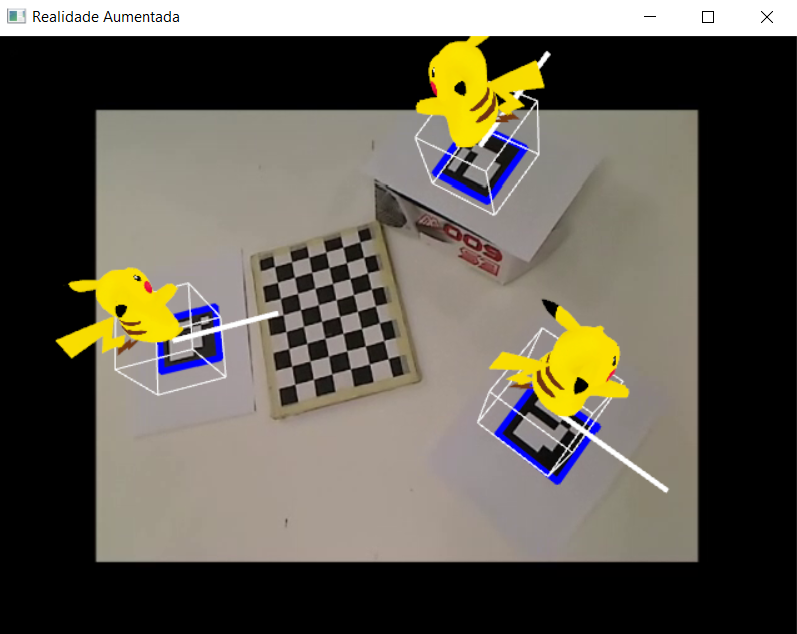 